## **Preparations**

In [24]:
import time
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import sklearn.model_selection as cv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    VotingClassifier,    
)

%matplotlib inline

In [25]:
#initializing stuff

# Load dataset
diabetes_df = pd.read_csv('../preprocessing_scripts/Data_preprocessed_10000.csv')
X, y = diabetes_df.drop(columns=["Diabetes_binary"]), diabetes_df["Diabetes_binary"]
X1, y1 = diabetes_df.drop(columns=["Diabetes_binary","MentHlth", "PhysHlth"]), diabetes_df["Diabetes_binary"]
print(X)
print(y)

#creating a test-train spilt

(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, y, test_size = .3, random_state = 42)
(X_train1, X_test1,  y_train1, y_test1) = cv.train_test_split(X1, y1, test_size = .3, random_state = 42)

#creating the stratified k-fold object to be used

SKFold = cv.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

      HighBP  HighChol  CholCheck       BMI  Smoker  Stroke  \
0        0.0       1.0        1.0 -1.071593     1.0     0.0   
1        0.0       0.0        1.0  0.628607     1.0     0.0   
2        1.0       1.0        1.0 -0.319133     1.0     0.0   
3        0.0       1.0        1.0  0.017644     1.0     0.0   
4        1.0       0.0        1.0  2.311887     0.0     0.0   
...      ...       ...        ...       ...     ...     ...   
9934     0.0       0.0        1.0 -0.319133     1.0     0.0   
9935     1.0       1.0        1.0  1.041359     1.0     0.0   
9936     1.0       1.0        1.0  0.177702     0.0     0.0   
9937     0.0       0.0        1.0 -1.723404     0.0     0.0   
9938     1.0       1.0        1.0 -1.279341     0.0     0.0   

      HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  AnyHealthcare  \
0                      0.0           1.0     0.0      1.0  ...            1.0   
1                      0.0           0.0     1.0      1.0  ...            1.0   


In [26]:
# Define a function to measure execution's time. It will be use as a 'decorator'
# The idea behind this is just to use it to estimate the time it will take for the
# full code to run if you want to know before training with the complete dataset
# using a subset of size known in relationship with the full dataset.
def compute_executions_time(function):
    def wrapper():
        start_time = time.time()  # init measuring time
        result = function()  # execute function
        print(f"\n{time.time() - start_time} seconds")  # print execution time
        return result
    return wrapper

In [27]:
def make_roc(classifier):
    RocCurveDisplay.from_estimator(
        classifier, 
        X_test, 
        y_test, 
        name = "ROC curve",
        color = "blue"  
    )   
    plt.title('ROC Curve in test set with defult threshold')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')



In [28]:
def plot_f1_scores_vs_parameter(parameter,parameter_list, scores_list, std_dev_list):
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        parameter_list,
        scores_list,
        yerr=std_dev_list,
        fmt='-o',
        ecolor='gray',
        elinewidth=1,
        capsize=3,
        label='Mean F1 Score ± Std'
    )
    plt.title(f"F1 Score vs {parameter} (with Standard Deviation)")
    plt.xlabel(f"{parameter}")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [29]:
def compare_classifiers_mcnemar(classifier1, classifier2):

    prediction_model_A = classifier1.predict(X_test)
    prediction_model_B = classifier2.predict(X_test)

    test = np.array(y_test)

    # [
    #   [Number of items misclassified by both A and B, Number of items misclassified by A but not by B ],
    #   [Number of items misclassified by B but not by A, Number of items classified correctly by both A and B]
    # ]
    both_right = [
        (test[i] == prediction_model_A[i]) and (test[i] == prediction_model_B[i]) 
        for i in range(len(y_test))
    ]

    only_B_right = [
        (test[i] != prediction_model_A[i]) and (test[i] == prediction_model_B[i])
        for i in range(len(y_test))
    ]

    only_A_right = [
        (test[i] == prediction_model_A[i]) and (test[i] != prediction_model_B[i])
        for i in range(len(y_test))
    ]

    both_wrong = [
        (test[i] != prediction_model_A[i]) and (test[i] != prediction_model_B[i])
        for i in range(len(test))
    ]

    # Compute the contingency table
    contingency_table = [
        [sum(both_right), sum(only_B_right)],
        [sum(only_A_right), sum(both_wrong)]
    ]
    print(f"Contingency table: {contingency_table}")

    significance_value = 0.05

    # McNemar's Test with the continuity correction
    results_mcnemar = mcnemar(contingency_table, exact=False, correction=True)
    print(f"Statistics value: {results_mcnemar.statistic}\np-value: {results_mcnemar.pvalue}")


    if results_mcnemar.pvalue < significance_value:
        print("Reject Null hypothesis")
    else:
        print("Fail to reject Null hypothesis -> we can not distinguish both models!")


## **Random Forest**

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72      1526
         1.0       0.70      0.77      0.73      1456

    accuracy                           0.72      2982
   macro avg       0.72      0.72      0.72      2982
weighted avg       0.73      0.72      0.72      2982

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71      1526
         1.0       0.69      0.76      0.72      1456

    accuracy                           0.72      2982
   macro avg       0.72      0.72      0.72      2982
weighted avg       0.72      0.72      0.72      2982



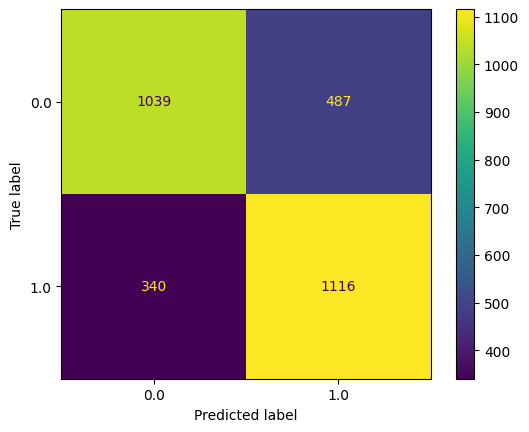

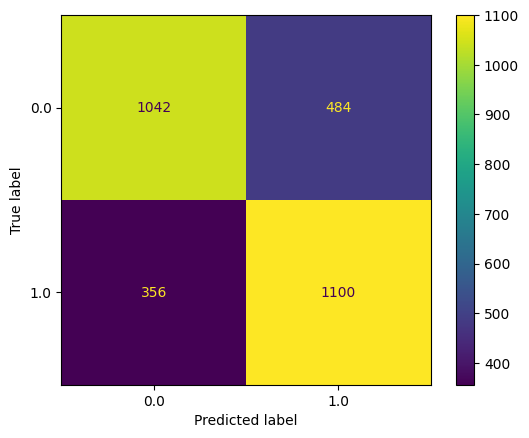

In [30]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

#testing dropping MentHlth, PhysHlth

rf1 = RandomForestClassifier(random_state=42)
rf1.fit(X_train1, y_train1)
predictions = rf1.predict(X_test1)
print(classification_report(y_test1, predictions))
ConfusionMatrixDisplay.from_predictions(y_test1,predictions)

In [31]:
@compute_executions_time
def execute_random_forest_with_different_estimators():
    parameter_list = []
    scores_list = []
    std_dev_list = []

    for n_trees in range(1, 201):
        random_forest_classifier = RandomForestClassifier(
            n_estimators=n_trees,
            random_state=42
        )
        scores = cross_val_score(
            estimator=random_forest_classifier,
            X=X_train,
            y=y_train,
            cv=SKFold,
            scoring="f1",
            n_jobs=-1
        )
        mean_score = scores.mean()
        std_dev_score = scores.std()
        print(f"F1-score: {mean_score:.5f} [nº estimators (trees): {n_trees}]")

        parameter_list.append(n_trees)
        scores_list.append(mean_score)
        std_dev_list.append(std_dev_score)

    return parameter_list, scores_list, std_dev_list


F1-score: 0.65388 [nº estimators (trees): 1]
F1-score: 0.56828 [nº estimators (trees): 2]
F1-score: 0.68997 [nº estimators (trees): 3]
F1-score: 0.65249 [nº estimators (trees): 4]
F1-score: 0.70576 [nº estimators (trees): 5]
F1-score: 0.68738 [nº estimators (trees): 6]
F1-score: 0.71986 [nº estimators (trees): 7]
F1-score: 0.70058 [nº estimators (trees): 8]
F1-score: 0.72375 [nº estimators (trees): 9]
F1-score: 0.71033 [nº estimators (trees): 10]
F1-score: 0.73139 [nº estimators (trees): 11]
F1-score: 0.71478 [nº estimators (trees): 12]
F1-score: 0.73198 [nº estimators (trees): 13]
F1-score: 0.71976 [nº estimators (trees): 14]
F1-score: 0.73572 [nº estimators (trees): 15]
F1-score: 0.72277 [nº estimators (trees): 16]
F1-score: 0.73487 [nº estimators (trees): 17]
F1-score: 0.72572 [nº estimators (trees): 18]
F1-score: 0.73801 [nº estimators (trees): 19]
F1-score: 0.73105 [nº estimators (trees): 20]
F1-score: 0.73909 [nº estimators (trees): 21]
F1-score: 0.73267 [nº estimators (trees): 2

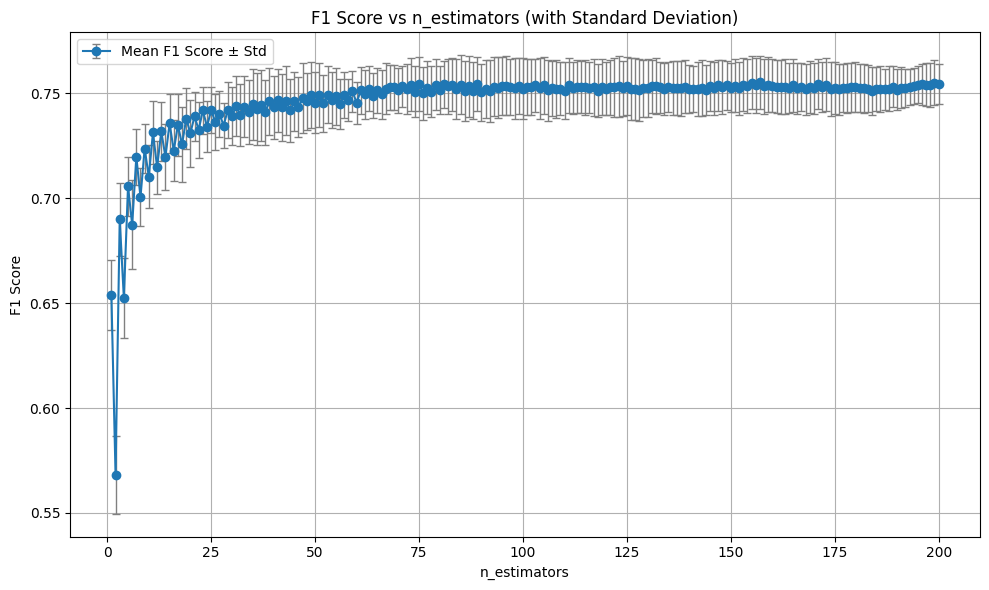

In [32]:
parameter_list, scores_list_rf, std_dev_list = execute_random_forest_with_different_estimators()
plot_f1_scores_vs_parameter("n_estimators",parameter_list, scores_list_rf, std_dev_list)

In [33]:
#testing statistical difference between n_estimators=75 and n_estimators=200
rf1 = RandomForestClassifier(n_estimators=200,random_state=42)
rf2 = RandomForestClassifier(n_estimators=75,random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Contingency table: [[np.int64(2112), np.int64(59)], [np.int64(53), np.int64(758)]]
Statistics value: 0.22321428571428573
p-value: 0.6366016325636008
Fail to reject Null hypothesis -> we can not distinguish both models!


              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72      1526
         1.0       0.70      0.78      0.74      1456

    accuracy                           0.73      2982
   macro avg       0.73      0.73      0.73      2982
weighted avg       0.73      0.73      0.73      2982

              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72      1526
         1.0       0.70      0.76      0.73      1456

    accuracy                           0.72      2982
   macro avg       0.73      0.73      0.72      2982
weighted avg       0.73      0.72      0.72      2982



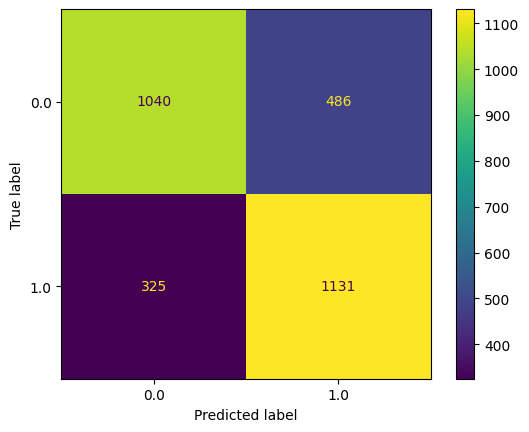

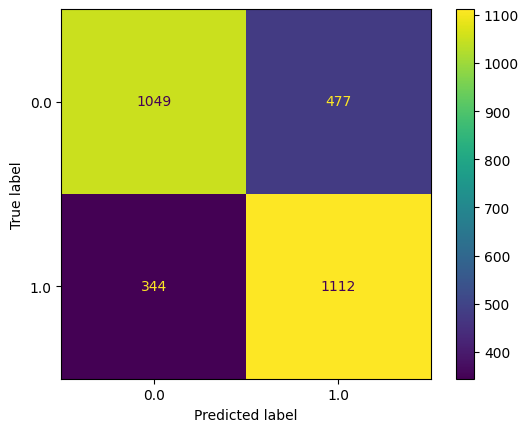

In [34]:
rf = RandomForestClassifier(n_estimators=75, random_state=42)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

# testing dropping MentHlth, PhysHlth

rf1 = RandomForestClassifier(n_estimators=75, random_state=42)
rf1.fit(X_train1, y_train1)
predictions = rf1.predict(X_test1)
print(classification_report(y_test1, predictions))
ConfusionMatrixDisplay.from_predictions(y_test1,predictions)

In [35]:
#determinacion de mejor combinación de n_estimators y max_features con GridSearch

params = {
    "n_estimators" : range(1,201,10),
    "max_features": ["sqrt", "log2", 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "random_state" : [42]
}

clf = GridSearchCV(estimator=RandomForestClassifier(),
            param_grid=params,
            scoring="f1",
            n_jobs=-1,
            cv=SKFold
            )
clf.fit(X_train,y_train)

print(clf.best_params_)
best_n_trees_rf = clf.best_params_["n_estimators"]
best_max_features_rf = clf.best_params_["max_features"]
print(clf.best_score_)

# 0.7571335804701635
# 0.7485721227808708 when dropping MentHlth, PhysHlth

{'max_features': 0.1, 'n_estimators': 141, 'random_state': 42}
0.7571335804701635


              precision    recall  f1-score   support

         0.0       0.76      0.67      0.71      1526
         1.0       0.69      0.78      0.73      1456

    accuracy                           0.72      2982
   macro avg       0.73      0.72      0.72      2982
weighted avg       0.73      0.72      0.72      2982



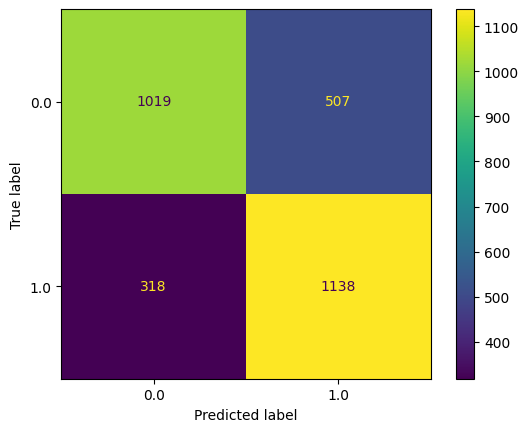

In [36]:
predictions = clf.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

In [37]:
#testing statistical difference between n_estimators=75 and best estimator according to gridSearch
rf1 = RandomForestClassifier(n_estimators=75,random_state=42)
rf1.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,clf.best_estimator_)

Contingency table: [[np.int64(2071), np.int64(86)], [np.int64(100), np.int64(725)]]
Statistics value: 0.9086021505376344
p-value: 0.3404855815313362
Fail to reject Null hypothesis -> we can not distinguish both models!


In [38]:
#determinación de mejor criterion

for criteria in ["gini", "entropy", "log_loss"]:
        random_forest_classifier = RandomForestClassifier(
            criterion = criteria,
            random_state=42
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X_train,
            y = y_train,
            cv=SKFold,
            scoring="f1",
            n_jobs=-1
        )

        print(f"F1-score: {scores.mean():.5f} [criterion: {criteria}]")


F1-score: 0.75234 [criterion: gini]
F1-score: 0.75211 [criterion: entropy]
F1-score: 0.75211 [criterion: log_loss]


In [39]:
#testing statistical difference between default and criterion="log_loss"
rf1 = RandomForestClassifier(random_state=42)
rf2 = RandomForestClassifier(criterion="log_loss",random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Contingency table: [[np.int64(2085), np.int64(92)], [np.int64(70), np.int64(735)]]
Statistics value: 2.7222222222222223
p-value: 0.09896015401940522
Fail to reject Null hypothesis -> we can not distinguish both models!


In [40]:
#testing statistical difference between default and criterion="entropy"
rf1 = RandomForestClassifier(random_state=42)
rf2 = RandomForestClassifier(criterion="entropy",random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Contingency table: [[np.int64(2085), np.int64(92)], [np.int64(70), np.int64(735)]]
Statistics value: 2.7222222222222223
p-value: 0.09896015401940522
Fail to reject Null hypothesis -> we can not distinguish both models!


In [41]:
#determinación de mejor max_depth

for depth in [None, 5,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,50]:
        random_forest_classifier = RandomForestClassifier(
            max_depth = depth,
            random_state=42
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X_train,
            y = y_train,
            cv=SKFold,
            scoring="f1",
            n_jobs=-1
        )

        print(f"F1-score: {scores.mean():.5f} [max_depth: {depth}]")

F1-score: 0.75234 [max_depth: None]
F1-score: 0.75580 [max_depth: 5]
F1-score: 0.76033 [max_depth: 10]
F1-score: 0.76144 [max_depth: 11]
F1-score: 0.76093 [max_depth: 12]
F1-score: 0.76105 [max_depth: 13]
F1-score: 0.75520 [max_depth: 14]
F1-score: 0.75906 [max_depth: 15]
F1-score: 0.75866 [max_depth: 16]
F1-score: 0.75538 [max_depth: 17]
F1-score: 0.75105 [max_depth: 18]
F1-score: 0.75310 [max_depth: 19]
F1-score: 0.75247 [max_depth: 20]
F1-score: 0.75085 [max_depth: 25]
F1-score: 0.75253 [max_depth: 30]
F1-score: 0.75207 [max_depth: 35]
F1-score: 0.75234 [max_depth: 40]
F1-score: 0.75234 [max_depth: 45]
F1-score: 0.75234 [max_depth: 50]


In [42]:
#testing statistical difference between default and max_depth=11
rf1 = RandomForestClassifier(random_state=42)
rf2 = RandomForestClassifier(max_depth=11,random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Contingency table: [[np.int64(2075), np.int64(110)], [np.int64(80), np.int64(717)]]
Statistics value: 4.426315789473684
p-value: 0.03538881782400586
Reject Null hypothesis


In [43]:
#testing statistical difference between n_estimators=75 and n_estimators=75+max_depth=11
rf1 = RandomForestClassifier(n_estimators=75,random_state=42)
rf2 = RandomForestClassifier(n_estimators=75,max_depth=11,random_state=42)
rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
compare_classifiers_mcnemar(rf1,rf2)

Contingency table: [[np.int64(2077), np.int64(115)], [np.int64(94), np.int64(696)]]
Statistics value: 1.9138755980861244
p-value: 0.16653338573116647
Fail to reject Null hypothesis -> we can not distinguish both models!


In [44]:
# "best" Random forest

BestRF = RandomForestClassifier(n_estimators=75,random_state=42)
BestRF.fit(X_train,y_train)

RandomForestClassifier(n_estimators=75, random_state=42)

## **Bagging**

              precision    recall  f1-score   support

         0.0       0.70      0.71      0.71      1526
         1.0       0.69      0.69      0.69      1456

    accuracy                           0.70      2982
   macro avg       0.70      0.70      0.70      2982
weighted avg       0.70      0.70      0.70      2982

              precision    recall  f1-score   support

         0.0       0.70      0.71      0.70      1526
         1.0       0.69      0.69      0.69      1456

    accuracy                           0.70      2982
   macro avg       0.70      0.70      0.70      2982
weighted avg       0.70      0.70      0.70      2982



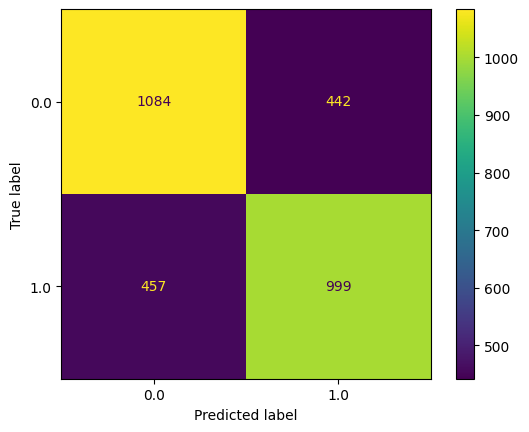

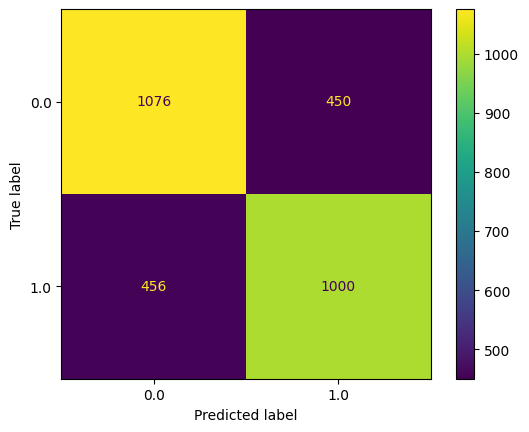

In [45]:
bg = BaggingClassifier(random_state=42)
bg.fit(X_train, y_train)
predictions = bg.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

# testing dropping MentHlth, PhysHlth

bg1 = BaggingClassifier(random_state=42)
bg1.fit(X_train1, y_train1)
predictions = bg1.predict(X_test1)
print(classification_report(y_test1, predictions))
ConfusionMatrixDisplay.from_predictions(y_test1,predictions)

In [46]:
# determinación de valores de n_estimators
@compute_executions_time
def execute_bagging_with_different_estimators():
    parameter_list = []
    scores_list = []
    std_dev_list = []
    for nest in range(1,201,1):
        scores = cross_val_score(
            BaggingClassifier(
                estimator = DecisionTreeClassifier(random_state=42),
                n_estimators = nest,
                random_state=42
            ), 
            X_train, 
            y_train, 
            cv = SKFold, 
            scoring="f1",
            n_jobs=-1
        )
        mean_score = scores.mean()
        std_dev_score = scores.std()
        print(f"F1-score: {mean_score:.5f} [nº estimators (trees): {nest}]")

        parameter_list.append(nest)
        scores_list.append(mean_score)
        std_dev_list.append(std_dev_score)

    return parameter_list, scores_list, std_dev_list

F1-score: 0.65931 [nº estimators (trees): 1]
F1-score: 0.56971 [nº estimators (trees): 2]
F1-score: 0.68520 [nº estimators (trees): 3]
F1-score: 0.64588 [nº estimators (trees): 4]
F1-score: 0.70425 [nº estimators (trees): 5]
F1-score: 0.67413 [nº estimators (trees): 6]
F1-score: 0.71178 [nº estimators (trees): 7]
F1-score: 0.68697 [nº estimators (trees): 8]
F1-score: 0.71669 [nº estimators (trees): 9]
F1-score: 0.69887 [nº estimators (trees): 10]
F1-score: 0.71934 [nº estimators (trees): 11]
F1-score: 0.70901 [nº estimators (trees): 12]
F1-score: 0.72328 [nº estimators (trees): 13]
F1-score: 0.71376 [nº estimators (trees): 14]
F1-score: 0.72739 [nº estimators (trees): 15]
F1-score: 0.71807 [nº estimators (trees): 16]
F1-score: 0.73054 [nº estimators (trees): 17]
F1-score: 0.72034 [nº estimators (trees): 18]
F1-score: 0.73207 [nº estimators (trees): 19]
F1-score: 0.72402 [nº estimators (trees): 20]
F1-score: 0.73579 [nº estimators (trees): 21]
F1-score: 0.72630 [nº estimators (trees): 2

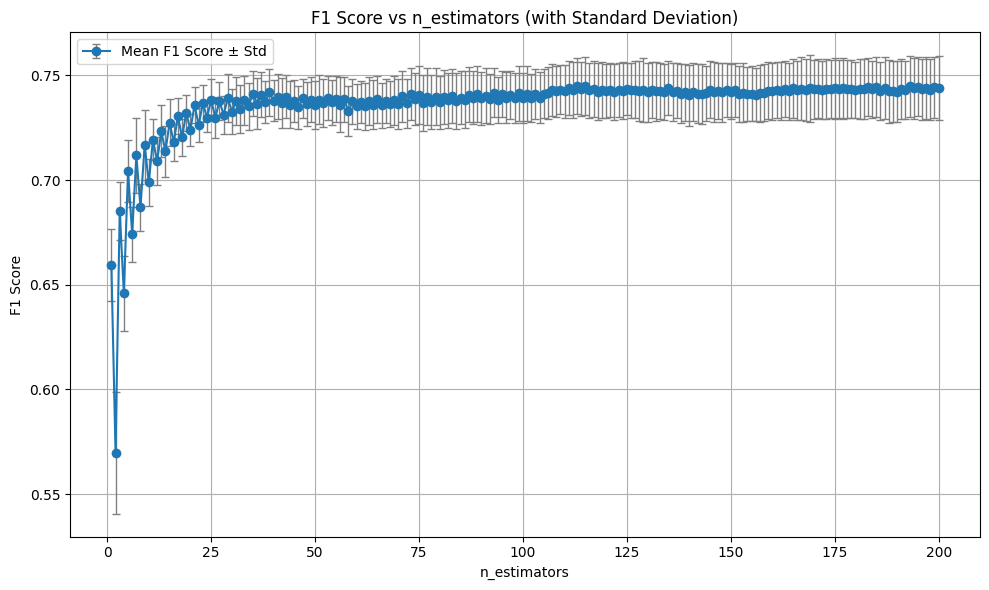

In [47]:
parameter_list, scores_list_bg, std_dev_list = execute_bagging_with_different_estimators()
plot_f1_scores_vs_parameter("n_estimators",parameter_list, scores_list_bg, std_dev_list)

In [48]:
#testing statistical difference between n_estimators=75 and n_estimators=200
bg1 = BaggingClassifier(estimator = DecisionTreeClassifier(random_state=42),n_estimators=75,random_state=42)
bg2 = BaggingClassifier(estimator = DecisionTreeClassifier(random_state=42),n_estimators=200,random_state=42)
bg1.fit(X_train, y_train)
bg2.fit(X_train, y_train)
compare_classifiers_mcnemar(bg1,bg2)

Contingency table: [[np.int64(2083), np.int64(63)], [np.int64(54), np.int64(782)]]
Statistics value: 0.5470085470085471
p-value: 0.4595425828742935
Fail to reject Null hypothesis -> we can not distinguish both models!


              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71      1526
         1.0       0.69      0.76      0.72      1456

    accuracy                           0.72      2982
   macro avg       0.72      0.72      0.72      2982
weighted avg       0.72      0.72      0.72      2982

              precision    recall  f1-score   support

         0.0       0.74      0.67      0.70      1526
         1.0       0.69      0.76      0.72      1456

    accuracy                           0.71      2982
   macro avg       0.71      0.71      0.71      2982
weighted avg       0.72      0.71      0.71      2982



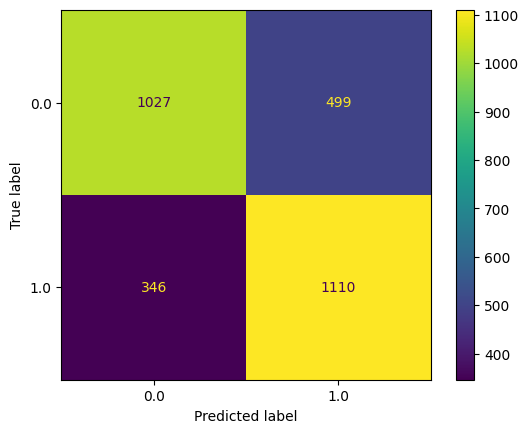

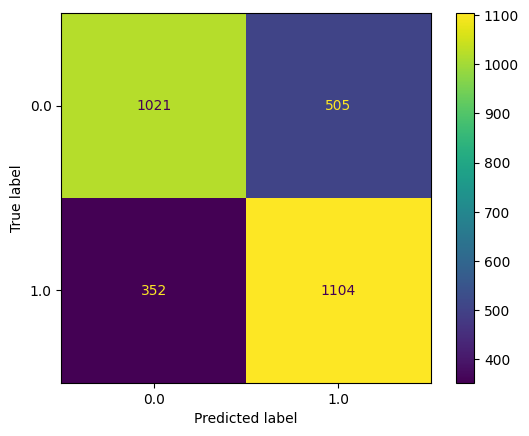

In [49]:
bg = BaggingClassifier(estimator = DecisionTreeClassifier(random_state=42),n_estimators=75,random_state=42)
bg.fit(X_train, y_train)
predictions = bg.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

# testing dropping MentHlth, PhysHlth

bg1 = BaggingClassifier(estimator = DecisionTreeClassifier(random_state=42),n_estimators=75,random_state=42)
bg1.fit(X_train1, y_train1)
predictions = bg1.predict(X_test1)
print(classification_report(y_test1, predictions))
ConfusionMatrixDisplay.from_predictions(y_test1,predictions)

In [50]:
# determinación de valores de max_samples

def execute_bagging_with_different_samples():
    parameter_list = []
    scores_list = []
    std_dev_list = []
    for max in [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00]:
        scores = cross_val_score(
            BaggingClassifier(
                estimator = DecisionTreeClassifier(random_state=42),
                max_samples = max,
                random_state=42
            ), 
            X_train, 
            y_train, 
            cv = SKFold, 
            scoring="f1",
            n_jobs=-1
        )
        mean_score = scores.mean()
        std_dev_score = scores.std()
        print(f"F1-score: {mean_score:.5f} [max_samples: {max}]")

        parameter_list.append(max)
        scores_list.append(mean_score)
        std_dev_list.append(std_dev_score)

    return parameter_list, scores_list, std_dev_list

F1-score: 0.71629 [max_samples: 0.05]
F1-score: 0.71122 [max_samples: 0.1]
F1-score: 0.70946 [max_samples: 0.15]
F1-score: 0.70869 [max_samples: 0.2]
F1-score: 0.70954 [max_samples: 0.25]
F1-score: 0.70775 [max_samples: 0.3]
F1-score: 0.70605 [max_samples: 0.35]
F1-score: 0.70693 [max_samples: 0.4]
F1-score: 0.69960 [max_samples: 0.45]
F1-score: 0.70562 [max_samples: 0.5]
F1-score: 0.70422 [max_samples: 0.55]
F1-score: 0.70211 [max_samples: 0.6]
F1-score: 0.70567 [max_samples: 0.65]
F1-score: 0.70721 [max_samples: 0.7]
F1-score: 0.70934 [max_samples: 0.75]
F1-score: 0.70182 [max_samples: 0.8]
F1-score: 0.69987 [max_samples: 0.85]
F1-score: 0.69955 [max_samples: 0.9]
F1-score: 0.69944 [max_samples: 0.95]
F1-score: 0.69887 [max_samples: 1.0]


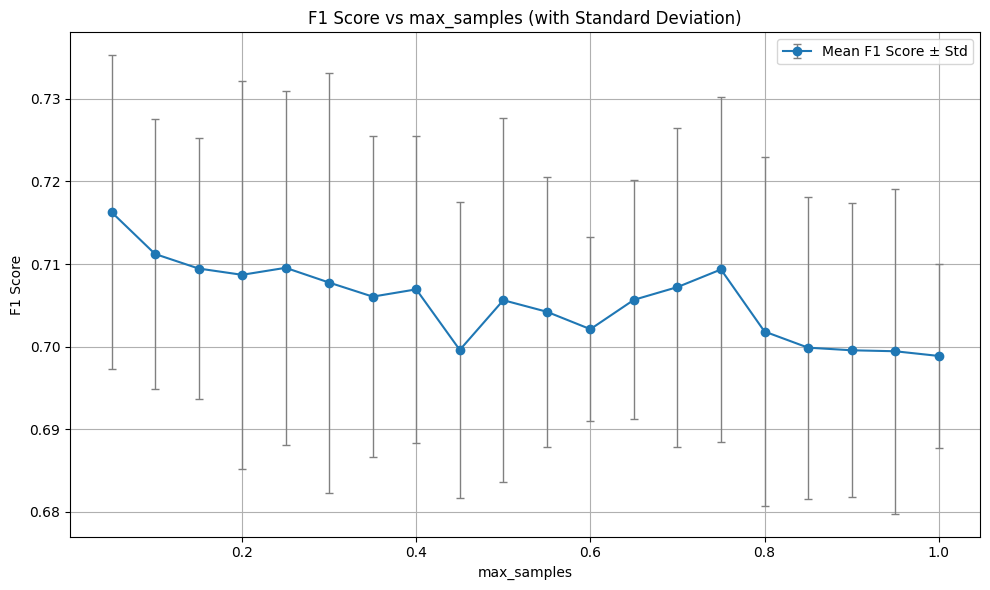

In [51]:
parameter_list, scores_list, std_dev_list = execute_bagging_with_different_samples()
plot_f1_scores_vs_parameter("max_samples",parameter_list, scores_list, std_dev_list)

In [52]:
#testing statistical difference between default and max_samples=0.1
bg1 = BaggingClassifier(estimator = DecisionTreeClassifier(random_state=42),random_state=42)
bg2 = BaggingClassifier(estimator = DecisionTreeClassifier(random_state=42),max_samples=0.1,random_state=42)
bg1.fit(X_train, y_train)
bg2.fit(X_train, y_train)
compare_classifiers_mcnemar(bg1,bg2)

Contingency table: [[np.int64(1799), np.int64(311)], [np.int64(284), np.int64(588)]]
Statistics value: 1.1361344537815126
p-value: 0.28647062113232735
Fail to reject Null hypothesis -> we can not distinguish both models!


In [53]:
# determinación de valores de max_features
for max in [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator = DecisionTreeClassifier(random_state=42),
            max_features= max,
            random_state=42
        ), 
        X_train, 
        y_train, 
        cv = SKFold, 
        scoring="f1",
        n_jobs=-1
    )
    print(f"F1-score: {scores.mean():.5f} [max_features: {max}]")

F1-score: 0.71000 [max_features: 0.05]
F1-score: 0.71937 [max_features: 0.1]
F1-score: 0.71871 [max_features: 0.15]
F1-score: 0.71679 [max_features: 0.2]
F1-score: 0.71656 [max_features: 0.25]
F1-score: 0.71461 [max_features: 0.3]
F1-score: 0.72642 [max_features: 0.35]
F1-score: 0.72178 [max_features: 0.4]
F1-score: 0.72498 [max_features: 0.45]
F1-score: 0.72482 [max_features: 0.5]
F1-score: 0.71425 [max_features: 0.55]
F1-score: 0.70729 [max_features: 0.6]
F1-score: 0.70550 [max_features: 0.65]
F1-score: 0.71150 [max_features: 0.7]
F1-score: 0.71153 [max_features: 0.75]
F1-score: 0.70076 [max_features: 0.8]
F1-score: 0.70688 [max_features: 0.85]
F1-score: 0.71078 [max_features: 0.9]
F1-score: 0.70870 [max_features: 0.95]
F1-score: 0.69887 [max_features: 1.0]


In [54]:
#testing statistical difference between default and max_features=0.35
bg1 = BaggingClassifier(estimator = DecisionTreeClassifier(random_state=42),random_state=42)
bg2 = BaggingClassifier(estimator = DecisionTreeClassifier(random_state=42),max_features=0.35,random_state=42)
bg1.fit(X_train, y_train)
bg2.fit(X_train, y_train)
compare_classifiers_mcnemar(bg1,bg2)

Contingency table: [[np.int64(1765), np.int64(327)], [np.int64(318), np.int64(572)]]
Statistics value: 0.09922480620155039
p-value: 0.7527618874278625
Fail to reject Null hypothesis -> we can not distinguish both models!


In [55]:
# "best" Bagging DT

BestBG = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),n_estimators=75,random_state=42)
BestBG.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=75, random_state=42)

## **Voting Scheme**

In [56]:
k_neighbors = KNeighborsClassifier()
params_space = {
    "n_neighbors": list(range(1, 101, 1)),
    "weights": ["distance", "uniform"]
}    
#search for best metaparameters for knn
clf = GridSearchCV(
    k_neighbors, 
    scoring="f1",
    param_grid = params_space,
    cv = SKFold,
    n_jobs = -1
)
clf.fit(X_train, y_train)
best_parameters_for_knn = clf.best_params_
print(f"Best Params fo Knn: {clf.best_params_} - f1-score: {clf.best_score_}")

knn = KNeighborsClassifier(
    n_neighbors = best_parameters_for_knn["n_neighbors"],
    weights = best_parameters_for_knn["weights"]
)

Best Params fo Knn: {'n_neighbors': 74, 'weights': 'distance'} - f1-score: 0.7433152342641025


In [57]:
@compute_executions_time
def execute_voting_scheme_different_estimators_grid_search():
    naive_bayes = GaussianNB()

    clf3 = DecisionTreeClassifier(random_state=42,criterion="gini", max_depth=4, min_samples_leaf=1, min_impurity_decrease=0.0, min_samples_split=2)

    for clf, label in zip([naive_bayes, knn, clf3], ["Naive Bayes","Knn", "Dec. Tree", ]):
        scores = cross_val_score(
            clf, 
            X_train, 
            y_train, 
            cv = SKFold, 
            n_jobs=-1,
            scoring = "f1"
        )
        print(f"F1-score: {scores.mean():.5f} [{label}]")

    warnings.filterwarnings("ignore", category=DeprecationWarning)  # Just to avoid warnings

    voting_classifier = VotingClassifier(
        estimators=[
            ("nb", naive_bayes),
            ("knn", knn),
            ("dt", clf3)
        ],
        voting = "hard"
    )
    scores = cross_val_score(
        voting_classifier,
        X_train,
        y_train,
        cv = SKFold,
        n_jobs=-1,
        scoring = "f1",)
    print("F1-score: %0.5f [%s]" % (scores.mean() , f"Majority Voting"))

    for w in [[0.66,0.167,0.166], [0.167,0.66,0.166], [0.167,0.166,0.66]]:
        voting_classifier = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "soft",
            weights=w
        )
        scores = cross_val_score(
            voting_classifier,
            X_train,
            y_train,
            cv = SKFold,
            n_jobs=-1,
            scoring = "f1")
        print("F1-score: %0.5f [%s]" % (scores.mean() , f"Weighted Voting with weights: {w}"))

execute_voting_scheme_different_estimators_grid_search()

F1-score: 0.71913 [Naive Bayes]
F1-score: 0.74332 [Knn]
F1-score: 0.74310 [Dec. Tree]
F1-score: 0.75363 [Majority Voting]
F1-score: 0.73039 [Weighted Voting with weights: [0.66, 0.167, 0.166]]
F1-score: 0.75218 [Weighted Voting with weights: [0.167, 0.66, 0.166]]
F1-score: 0.75097 [Weighted Voting with weights: [0.167, 0.166, 0.66]]

0.9884634017944336 seconds


              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71      1526
         1.0       0.69      0.77      0.73      1456

    accuracy                           0.72      2982
   macro avg       0.72      0.72      0.72      2982
weighted avg       0.72      0.72      0.72      2982

              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72      1526
         1.0       0.70      0.79      0.74      1456

    accuracy                           0.73      2982
   macro avg       0.74      0.73      0.73      2982
weighted avg       0.74      0.73      0.73      2982



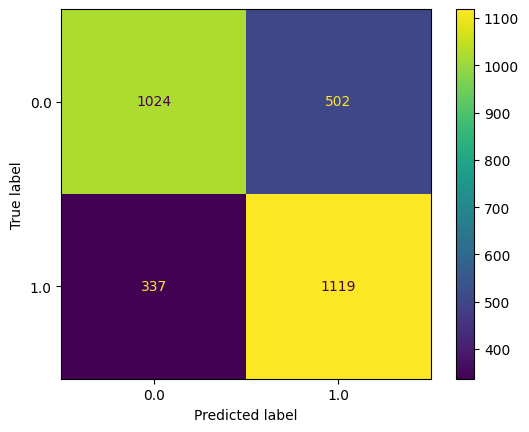

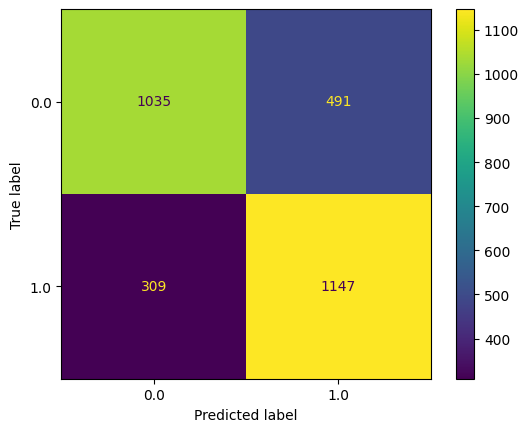

In [58]:
naive_bayes = GaussianNB()

clf3 = DecisionTreeClassifier(random_state=42,criterion="gini", max_depth=4, min_samples_leaf=1, min_impurity_decrease=0.0, min_samples_split=2)

vt = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "hard"
)

vt.fit(X_train,y_train)
predictions = vt.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

# testing dropping MentHlth, PhysHlth

vt1 = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "hard"
)

vt1.fit(X_train1,y_train1)
predictions = vt1.predict(X_test1)
print(classification_report(y_test1, predictions))
ConfusionMatrixDisplay.from_predictions(y_test1,predictions)

In [59]:
naive_bayes = GaussianNB()

clf3 = DecisionTreeClassifier(random_state=42,criterion="gini", max_depth=4, min_samples_leaf=1, min_impurity_decrease=0.0, min_samples_split=2)

vt1 = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "soft",
            weights=[0.167, 0.66, 0.166]
)
vt2 = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "hard"
)
vt1.fit(X_train,y_train)
vt2.fit(X_train,y_train)

compare_classifiers_mcnemar(vt1,vt2)

Contingency table: [[np.int64(2087), np.int64(56)], [np.int64(68), np.int64(771)]]
Statistics value: 0.9758064516129032
p-value: 0.32323632332476787
Fail to reject Null hypothesis -> we can not distinguish both models!


In [60]:
# "best" Majority Voting

BestVT = VotingClassifier(
            estimators=[
                ("nb", naive_bayes),
                ("knn3", knn),
                ("dt", clf3)
            ],
            voting = "hard"
)
BestVT.fit(X_train,y_train)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('knn3',
                              KNeighborsClassifier(n_neighbors=74,
                                                   weights='distance')),
                             ('dt',
                              DecisionTreeClassifier(max_depth=4,
                                                     random_state=42))])

## **Ada Boost Classifier**

In [61]:
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers():
    parameter_list = []
    scores_list = []
    std_dev_list = []
    for nest in range(1,201,1):
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=nest,
            random_state=42
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X_train,
            y_train,
            cv = SKFold,
            n_jobs=-1,
            scoring = "f1"
        )
        mean_score = scores.mean()
        std_dev_score = scores.std()
        print(f"F1-score: {mean_score:.5f} [n_estimators: {nest}]")

        parameter_list.append(nest)
        scores_list.append(mean_score)
        std_dev_list.append(std_dev_score)

    return parameter_list, scores_list, std_dev_list

F1-score: 0.71115 [n_estimators: 1]
F1-score: 0.71115 [n_estimators: 2]
F1-score: 0.73907 [n_estimators: 3]
F1-score: 0.73772 [n_estimators: 4]
F1-score: 0.73476 [n_estimators: 5]
F1-score: 0.74706 [n_estimators: 6]
F1-score: 0.74034 [n_estimators: 7]
F1-score: 0.74452 [n_estimators: 8]
F1-score: 0.74075 [n_estimators: 9]
F1-score: 0.74930 [n_estimators: 10]
F1-score: 0.74517 [n_estimators: 11]
F1-score: 0.74819 [n_estimators: 12]
F1-score: 0.74415 [n_estimators: 13]
F1-score: 0.74767 [n_estimators: 14]
F1-score: 0.74746 [n_estimators: 15]
F1-score: 0.74569 [n_estimators: 16]
F1-score: 0.74526 [n_estimators: 17]
F1-score: 0.74703 [n_estimators: 18]
F1-score: 0.74761 [n_estimators: 19]
F1-score: 0.74882 [n_estimators: 20]
F1-score: 0.74896 [n_estimators: 21]
F1-score: 0.75054 [n_estimators: 22]
F1-score: 0.75020 [n_estimators: 23]
F1-score: 0.74985 [n_estimators: 24]
F1-score: 0.75254 [n_estimators: 25]
F1-score: 0.75060 [n_estimators: 26]
F1-score: 0.75177 [n_estimators: 27]
F1-score: 

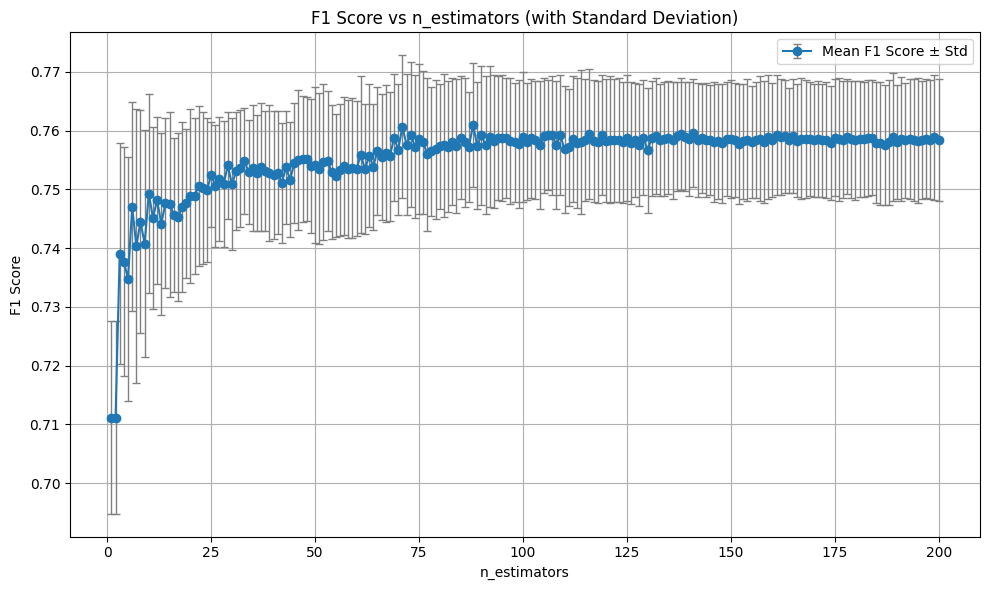

In [62]:
parameter_list, scores_list_ada, std_dev_list = execute_ada_boost_classifier_for_different_classifiers()
plot_f1_scores_vs_parameter("n_estimators",parameter_list, scores_list_ada, std_dev_list)

              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1526
         1.0       0.72      0.76      0.74      1456

    accuracy                           0.74      2982
   macro avg       0.74      0.74      0.74      2982
weighted avg       0.74      0.74      0.74      2982

              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1526
         1.0       0.71      0.76      0.74      1456

    accuracy                           0.73      2982
   macro avg       0.74      0.74      0.73      2982
weighted avg       0.74      0.73      0.73      2982



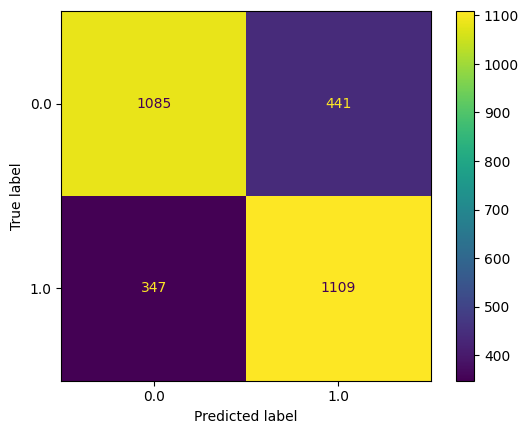

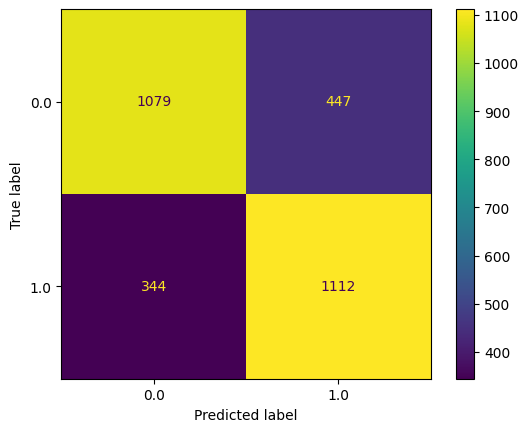

In [63]:
ada=AdaBoostClassifier(random_state=42,n_estimators=100)
ada.fit(X_train,y_train)
predictions = ada.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions)

# testing dropping MentHlth, PhysHlth

ada1=AdaBoostClassifier(random_state=42,n_estimators=100)
ada1.fit(X_train1,y_train1)
predictions = ada1.predict(X_test1)
print(classification_report(y_test1, predictions))
ConfusionMatrixDisplay.from_predictions(y_test1,predictions)

In [64]:
#determinacion de mejor combinación de n_estimators y learning_rate con GridSearch

params = {
    "n_estimators" : range(1,201,10),
    "learning_rate": [0.1,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0],
    "random_state": [42]
}

clf = GridSearchCV(estimator=AdaBoostClassifier(),
            param_grid=params,
            scoring="f1",
            n_jobs=-1,
            cv=SKFold,
            )
clf.fit(X_train,y_train)

print(clf.best_params_)
best_n_est_ada = clf.best_params_["n_estimators"]
best_learning_rate_ada = clf.best_params_["learning_rate"]
print(clf.best_score_)

{'learning_rate': 0.5, 'n_estimators': 141, 'random_state': 42}
0.7612265080580098


In [65]:
ada1 = AdaBoostClassifier(n_estimators=100,random_state=42)
ada1.fit(X_train,y_train)
compare_classifiers_mcnemar(ada1,clf.best_estimator_)

Contingency table: [[np.int64(2134), np.int64(59)], [np.int64(60), np.int64(729)]]
Statistics value: 0.0
p-value: 1.0
Fail to reject Null hypothesis -> we can not distinguish both models!


In [66]:
# Best Adaboost

BestADA = AdaBoostClassifier(n_estimators=100,random_state=42)
BestADA.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

## **Comparison between classfiers with ROC curve**

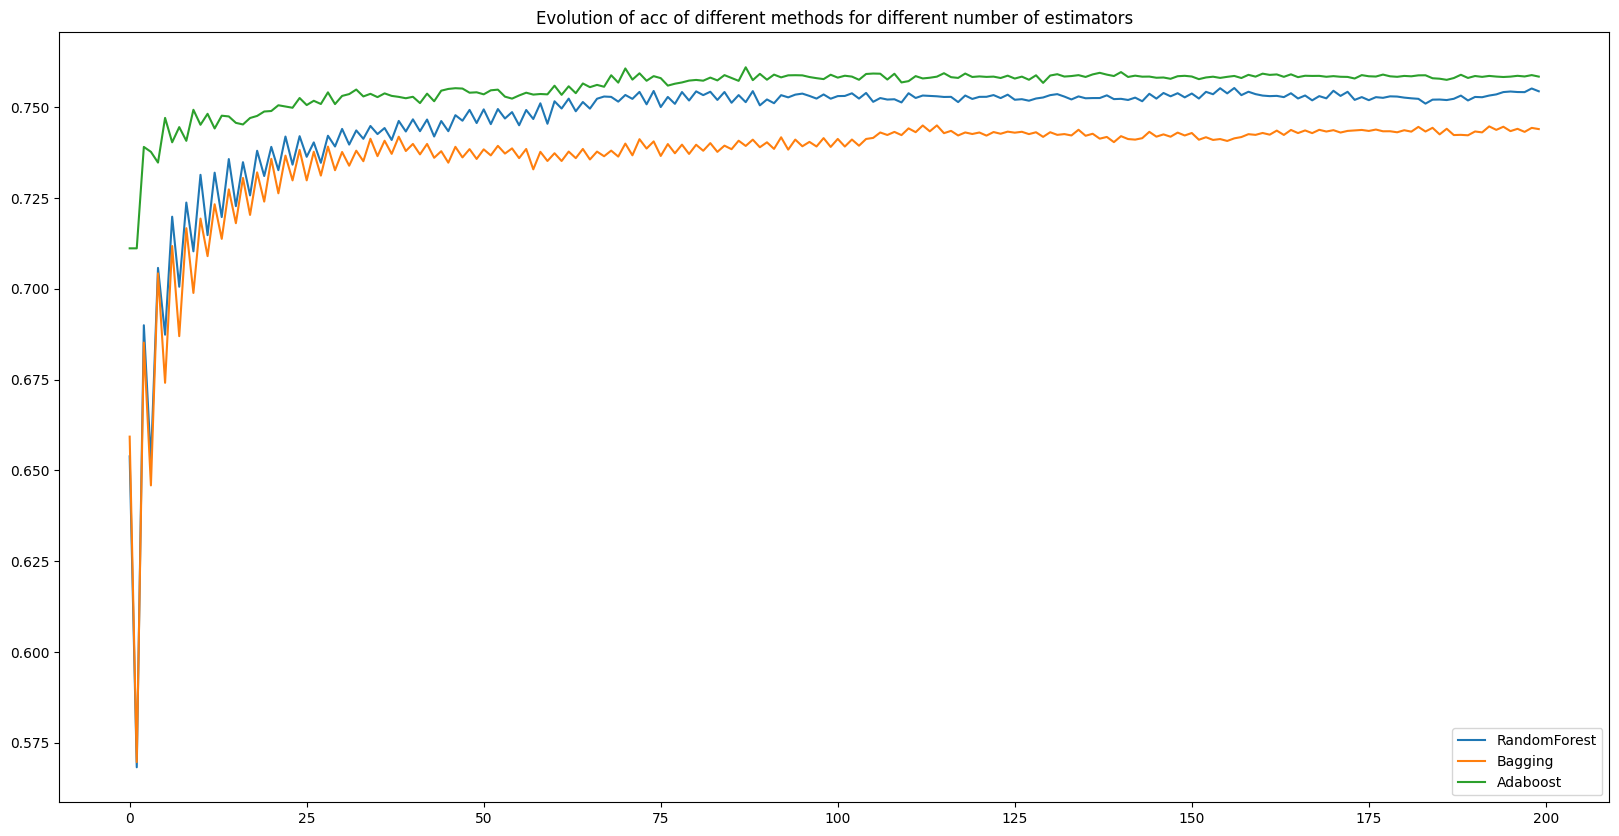

In [67]:
plt.figure(figsize = (20, 10))
plt.title("Evolution of acc of different methods for different number of estimators")
plt.plot(scores_list_rf,label = "RandomForest")
plt.plot(scores_list_bg,label = "Bagging")
plt.plot(scores_list_ada,label = "Adaboost")
plt.legend(loc = "lower right")
plt.show()

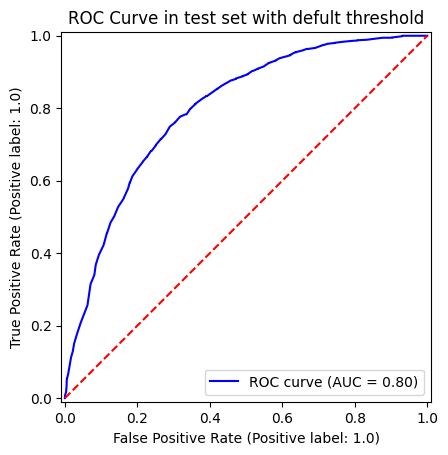

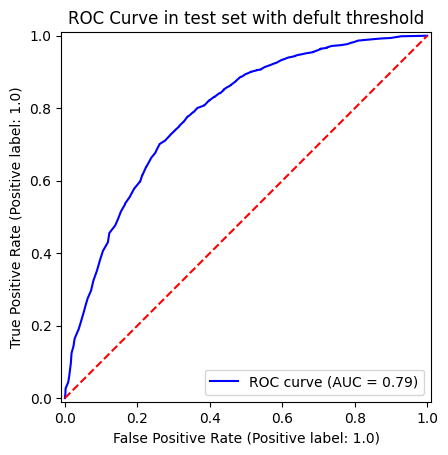

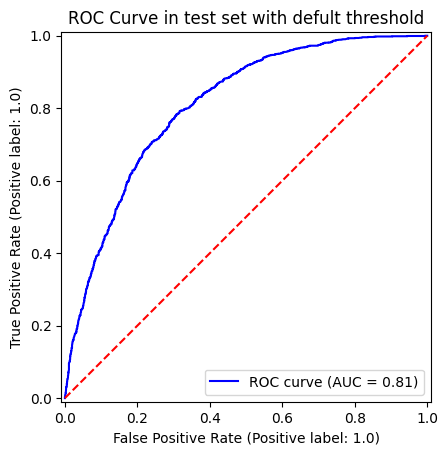

In [68]:
# Represent the ROC curve for the Random Forest

make_roc(BestRF)

# Represent the ROC curve for the Bagging DT

make_roc(BestBG)

# Can't represent the ROC curve for the Majority Voting since it has no probabilities

# Represent the ROC curve for the Adaboost

make_roc(BestADA)